# **Fantasy Sports League Optimization**

## **Project Description**
This project focuses on optimizing team assignments in a fantasy sports league while ensuring a balanced distribution of talent and adherence to salary constraints. Given a dataset of players with attributes such as skill rating, cost, and position, we aim to assign them to five teams while following strict constraints and achieving a balanced league.

## **Constraints**
- Each team must consist of:
  - 1 Goalkeeper (GK)  
  - 2 Defenders (DEF)  
  - 2 Midfielders (MID)  
  - 2 Forwards (FWD)  
- Each player is assigned to exactly one team.  
- No team may exceed a total budget of **750 million €**.  
- The standard deviation of the average skill rating of all teams should be minimized to ensure fairness.  

## **Objective**
To generate a valid league configuration that follows all constraints and ensures that teams have a similar overall skill level, measured by the standard deviation of their average skill ratings.

**Notebook oblective:**

In this notebook, we run the final genetic algorithm using the selected configuration.

- First, we execute every available combination of mutation, selection, and crossover operators multiple times. For each configuration, we compute the average of the best fitness scores obtained over many runs.
- We then compare these averages to determine which configuration produces the lowest (best) fitness value.
- Based on our tests, we selected the configuration with the lowest average best fitness—namely, the Roulette Wheel Scramble Position-based variant—for the final run.

## **Group Members**

### **Group X**

| Name                  | Student Number  |
|-----------------------|----------------|
| Philippe Dutranoit   | 20240518        |
| Josua Wehr        | 202040501 |
| Benedikt Ruggaber | 202040500 |
| Daan Van Holten  | 20240681 |

# Imports

In [1]:
#%pip install scipy.stats

In [2]:
# import relavant libraries
import pandas as pd
import numpy as np
import random
import time
import inspect

import matplotlib.pyplot as plt
from itertools import product, combinations
from scipy.stats import ranksums

# import all custom classes
from CrossoverMethods import CrossoverMethods
from League import League
from GeneticAlgorithm import *
from MutationMethods import MutationMethods
from Player import Player
from SelectionMethods import SelectionMethods
from SolutionAnalyzer import SolutionAnalyzer
from Team import Team

# Preset

In [3]:
random.seed(42) # set up random seed for reproducibility
NUM_TEAMS = 5
PLAYERS_PER_TEAM = 7
BUDGET_LIMIT = 750

In [4]:
df = pd.read_csv('../Data/players(in).csv')

# Print all available classes from GeneticAlgorithm
ga_classes = [name for name, obj in globals().items() 
              if name.startswith('GeneticAlgorithm_') and inspect.isclass(obj)]
print(f"Their is {len(ga_classes)} different genetic algorithm")
print(ga_classes)

Their is 12 different genetic algorithm
['GeneticAlgorithm_tournament_swap_team', 'GeneticAlgorithm_tournament_swap_positionbased', 'GeneticAlgorithm_tournament_positionshuffle_team', 'GeneticAlgorithm_tournament_positionshuffle_positionbased', 'GeneticAlgorithm_tournament_scramble_team', 'GeneticAlgorithm_tournament_scramble_positionbased', 'GeneticAlgorithm_roulette_wheel_swap_team', 'GeneticAlgorithm_roulette_wheel_swap_positionbased', 'GeneticAlgorithm_roulette_wheel_positionshuffle_team', 'GeneticAlgorithm_roulette_wheel_positionshuffle_positionbased', 'GeneticAlgorithm_roulette_wheel_scramble_team', 'GeneticAlgorithm_roulette_wheel_scramble_positionbased']


In [5]:
# Test if their is enough player to form every team
players = [
    Player(
        id=i,
        name=row['Name'],
        position=row['Position'],
        skill=row['Skill'],
        salary=row['Salary (€M)']
    )
    for i, row in df.iterrows()
]

# count how many players per position
positions = {}
for player in players:
    positions[player.position] = positions.get(player.position, 0) + 1
print(f"Players by position:{positions}")

Players by position:{'GK': 5, 'DEF': 10, 'MID': 10, 'FWD': 10}


There are enough players at each position. With at least two players available per role, we meet the requirement (since 10/2=5), and we require only one goalkeeper per team.

# Algorithm Evaluation

In this section, we run every combination of selection, crossover, and mutation operators to compare their performance. By averaging the best fitness across multiple runs, we can identify the most effective configuration and use it for our final prediction.

## Model Runs

In [6]:
# # Step 1: Define the components of the algorithm variants
# # These represent all possible values for selection, mutation, and crossover strategies
# selection_methods = ['tournament', 'roulette_wheel']
# mutation_strategies = ['swap', 'positionshuffle', 'scramble']
# crossover_strategies = ['team', 'positionbased']

# # Step 2: Define a function to dynamically retrieve the GeneticAlgorithm class
# # based on the naming convention, e.g., 'GeneticAlgorithm_tournament_scramble_team'
# def get_algorithm_class(selection, mutation, crossover):
#     class_name = f"GeneticAlgorithm_{selection}_{mutation}_{crossover}"
#     return globals().get(class_name)  # Retrieves the class object from the global namespace

# # Step 3: Prepare a list to store the results from each configuration
# results = []

# # Step 4: Iterate over all combinations of the algorithm components
# for selection, mutation, crossover in product(selection_methods, mutation_strategies, crossover_strategies):
#     ga_class = get_algorithm_class(selection, mutation, crossover)

#     # Step 5: Check if the class actually exists before running
#     if ga_class is not None:
#         print(f"Running: {ga_class.__name__}")

#         # Step 6: Run the genetic algorithm with the current configuration
#         # compute_avg_best_fitness returns the average best-fitness per generation
#         df = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=ga_class)

#         # Step 7: Add metadata columns to keep track of the configuration used
#         df['Selection'] = selection
#         df['Mutation'] = mutation
#         df['Crossover'] = crossover

#         # Step 8: Append the result to the results list
#         results.append(df)
#     else:
#         print(f"Class not found: {selection}, {mutation}, {crossover}")

# # Step 9: Concatenate all result DataFrames into a single DataFrame
# # This makes it easier to analyze and compare performance across configurations
# final_df = pd.concat(results, ignore_index=True)


For every combination of **Genetic Algorithm** we run them and put the run history into a dataframe which is named after the different selection, crossover, mutation used. Those dataframe will be used after to analyse the different reuslts

In [7]:
def Multiple_runs(players, n_runs=1000, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_swap_team):
    """Run the GA n number of times and return the best fitness per generation"""
    runs = []
    gens = []
    fitnesses = []

    for run in range(n_runs):
        ga = GeneticAlgorithm_tournament_swap_team(players, pop_size=pop_size, generations=generations)
        _, history = ga.run()
       # extract the info from history and append every thing to the list
        for gen, fit in enumerate(history):
            runs.append(run)
            gens.append(gen)
            fitnesses.append(fit)

    df= pd.DataFrame({
        'Run': runs,
        'Generation': gens,
        'BestFitness': fitnesses})
    return df.sort_values(['Generation', 'Run']).reset_index(drop=True)

df_names = []
# make the run for every GA class
for ga_class_name in ga_classes:
    GA_class = globals()[ga_class_name]
    # create variable name by replacing "GeneticAlgorithm" with "df"
    var_name = "df_" + ga_class_name.split("GeneticAlgorithm_")[-1]
    df_names.append(var_name)
    globals()[var_name] = Multiple_runs(players, n_runs= 100, pop_size=35, generations=100, GeneticAlgorithm=GA_class)
    print(df_names)

Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.5222
Generation 0: Best fitness = 0.3659 (Time: 0.01s)
Generation 10: Best fitness = 0.3182 (Time: 0.08s)
Generation 20: Best fitness = 0.1666 (Time: 0.14s)
Generation 30: Best fitness = 0.1069 (Time: 0.20s)
Generation 40: Best fitness = 0.0571 (Time: 0.27s)
Generation 50: Best fitness = 0.0571 (Time: 0.33s)
Generation 60: Best fitness = 0.0571 (Time: 0.40s)
Generation 70: Best fitness = 0.0571 (Time: 0.48s)
Generation 80: Best fitness = 0.0571 (Time: 0.54s)
Generation 90: Best fitness = 0.0571 (Time: 0.61s)
Generation 99: Best fitness = 0.0571 (Time: 0.67s)
Evolution completed in 0.67 seconds
Final best fitness: 0.0571
Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.1895
Generation 0: Best fitness = 0.1895 (Time: 0.01s)
Generation 10: Best fitness = 0.1895 (Time: 0.07s)
Generation 20: Best fitness = 0.1895 (Time: 0.13s)
Generation 30: Best fitness = 0.1400 (Time: 0.20s)
Ge

## Model Comparasion

To have a first idea of how the different combination compare we first group them by generation and then merged them into a single dataframe in order to plot them.

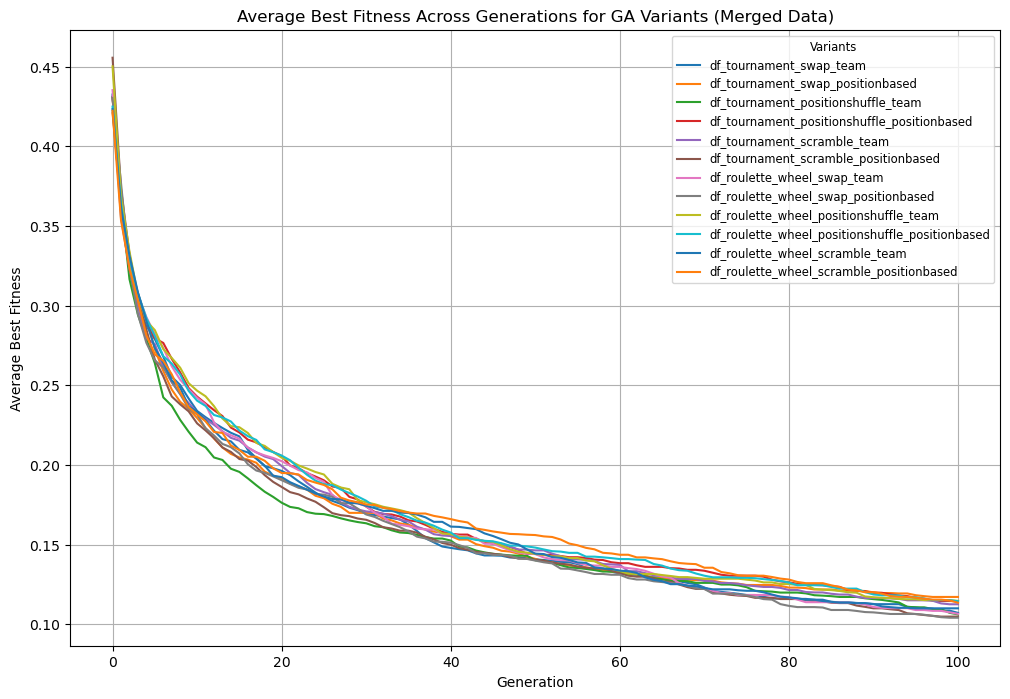

In [25]:
df_grouped = []
for df in df_names:
    df_ = globals()[df]
    grouped = df_.groupby('Generation', as_index=False)['BestFitness'].mean()
    # Rename 'BestFitness' column to the dataframe's name
    grouped.rename(columns={'BestFitness': df}, inplace=True)
    df_grouped.append(grouped)

# Merge all dataframes on 'Generation'
merged_df = df_grouped[0]
for df_next in df_grouped[1:]:
    merged_df = pd.merge(merged_df, df_next, on='Generation', how='outer')

merged_df = merged_df.sort_values('Generation').reset_index(drop=True)
merged_df

ax = merged_df.set_index('Generation').plot(grid=True)
ax.set_title("Average Best Fitness Across Generations for GA Variants (Merged Data)")
ax.set_xlabel("Generation")
ax.set_ylabel("Average Best Fitness")
plt.legend(title="Variants", loc='upper right')
plt.gcf().set_size_inches(12, 8)
plt.legend(title="Variants", loc='upper right', fontsize='small', title_fontsize='small')
plt.show()

We then use a Rank Sum test to further compare the performance of each algorithm. Thus, we analyze the final generation results from each configuration with this test to statistically validate which algorithm consistently yields the best outcomes.

In [9]:
dfs_last = []
for df in df_names:
    df_run = globals()[df]
    # or each run find the row with the maximum Generation
    idx = df_run.groupby('Run')['Generation'].idxmax()
    last_generation = df_run.loc[idx].copy()
    # rename the BestFitness column to the dataframe variable name
    last_generation.rename(columns={'BestFitness': df}, inplace=True)
    last_generation = last_generation[['Run', df]]
    dfs_last.append(last_generation)

# merge all results on the 'Run' column
merged_last_run_df = dfs_last[0]
for next_df in dfs_last[1:]:
    merged_last_run_df = pd.merge(merged_last_run_df, next_df, on='Run', how='outer')

print(merged_last_run_df)

    Run  df_tournament_swap_team  df_tournament_swap_positionbased  \
0     0                 0.057143                          0.166599   
1     1                 0.057143                          0.106904   
2     2                 0.057143                          0.166599   
3     3                 0.166599                          0.057143   
4     4                 0.057143                          0.106904   
..  ...                      ...                               ...   
95   95                 0.106904                          0.106904   
96   96                 0.106904                          0.106904   
97   97                 0.057143                          0.106904   
98   98                 0.057143                          0.166599   
99   99                 0.057143                          0.057143   

    df_tournament_positionshuffle_team  \
0                             0.139971   
1                             0.057143   
2                             0.1

In [23]:
alpha = 0.05
metrics = [c for c in merged_last_run_df.columns if c != 'Run']

for col1, col2 in combinations(metrics, 2):
    data1 = merged_last_run_df[col1].values
    data2 = merged_last_run_df[col2].values

    stat, p = ranksums(data1, data2)
    if p > alpha:
        print(f"{col1} vs {col2}: stat = {stat:.3f}, p = {p:.3e}  (not significant at α={alpha})")

minimum = merged_last_run_df[metrics].min()
best_combination = minimum.idxmin()
best_combinatio_value = minimum.min()
print(f"\nBest combination across multiple run is {best_combination}: {best_combinatio_value}")


df_tournament_swap_team vs df_tournament_swap_positionbased: stat = -1.629, p = 1.034e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_tournament_positionshuffle_team: stat = 0.334, p = 7.387e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_tournament_positionshuffle_positionbased: stat = -1.053, p = 2.923e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_tournament_scramble_team: stat = -0.886, p = 3.758e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_tournament_scramble_positionbased: stat = 0.393, p = 6.940e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_roulette_wheel_swap_team: stat = 0.180, p = 8.575e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_roulette_wheel_swap_positionbased: stat = 0.557, p = 5.775e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_roulette_wheel_positionshuffle_team: stat = -1.272, p = 2.034e-01  (not significant at α=0.05)
df_tournament_swap_team vs df_roule

# Final Prediction
For the final prediction we use the algorithm that yield the best result above

In [11]:
Best_ga = GeneticAlgorithm_roulette_wheel_scramble_positionbased(players, pop_size=35,generations=100)
best_league, fitness_history = Best_ga.run()

Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.4729
Generation 0: Best fitness = 0.4180 (Time: 0.08s)
Generation 10: Best fitness = 0.2458 (Time: 0.66s)
Generation 20: Best fitness = 0.1400 (Time: 1.24s)
Generation 30: Best fitness = 0.1400 (Time: 1.83s)
Generation 40: Best fitness = 0.1069 (Time: 2.42s)
Generation 50: Best fitness = 0.1069 (Time: 3.00s)
Generation 60: Best fitness = 0.0571 (Time: 3.59s)
Generation 70: Best fitness = 0.0571 (Time: 4.18s)
Generation 80: Best fitness = 0.0571 (Time: 4.77s)
Generation 90: Best fitness = 0.0571 (Time: 5.36s)
Generation 99: Best fitness = 0.0571 (Time: 5.90s)
Evolution completed in 5.90 seconds
Final best fitness: 0.0571


In [12]:
print("FANTASY LEAGUE SOLUTION ANALYSIS")
print(f"League Standard Deviation: {best_league.get_skill_std_dev():.4f}")
for i, t in enumerate(best_league.teams):
    print(f"\nTeam {i+1}:")
    print(f"Average Skill: {t.get_avg_skill():.2f}")
    print(f"Total Salary: {t.get_total_salary()}M€")
    print("Team composition:")
    # get the players for each position in each team
    for pos in ['GK', 'DEF', 'MID', 'FWD']:
        pos_players = [p for p in t.players if p.position == pos]
        print(f"    {pos}:")
        for player in pos_players:
            print(f"        - {player.name}(Skill:{player.skill}, Salary:{player.salary}M€)")



FANTASY LEAGUE SOLUTION ANALYSIS
League Standard Deviation: 0.0571

Team 1:
Average Skill: 86.43
Total Salary: 685M€
Team composition:
    GK:
        - Jordan Smith(Skill:88, Salary:100M€)
    DEF:
        - Lucas Bennett(Skill:85, Salary:90M€)
        - Ethan Howard(Skill:80, Salary:70M€)
    MID:
        - Gavin Richardson(Skill:87, Salary:95M€)
        - Spencer Ward(Skill:84, Salary:85M€)
    FWD:
        - Sebastian Perry(Skill:95, Salary:150M€)
        - Chase Murphy(Skill:86, Salary:95M€)

Team 2:
Average Skill: 86.29
Total Salary: 675M€
Team composition:
    GK:
        - Ryan Mitchell(Skill:83, Salary:85M€)
    DEF:
        - Brayden Hughes(Skill:87, Salary:100M€)
        - Mason Reed(Skill:82, Salary:75M€)
    MID:
        - Nathan Wright(Skill:92, Salary:120M€)
        - Dylan Morgan(Skill:91, Salary:115M€)
    FWD:
        - Landon Powell(Skill:89, Salary:110M€)
        - Tyler Jenkins(Skill:80, Salary:70M€)

Team 3:
Average Skill: 86.43
Total Salary: 682M€
Team compositio

# Export

In [13]:
fliname = 'best_solution.csv'
data = []
for team_idx, team in enumerate(best_league.teams):
    for player in team.players:
        data.append({
        'Team': f'Team {team_idx+1}',
        'PlayerID': player.id,
        'Name': player.name,
        'Position': player.position,
        'Skill': player.skill,
        'Salary': player.salary})
        
df = pd.DataFrame(data)
df.to_csv(fliname, index=False)

TODO:

- SolutionAnalyzer kick out or atleast code it else way (Phil)
- Compare the diffrent algorithms in a chart (Phil)
- comments (Josh)



Report:
- Check Search Space (Daan)
- finsh up report ()
- 
